# **Meerkat Call Classifier**

This code takes in examples of calls of different types, trains a conv net model to detect which type, then can run this on new data.

In [20]:
#from Jake

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import load_model
import os
import numpy as np
import librosa
import scipy.signal as spy
import pandas as pd
from meerkat_call_detector_library import *

#params
train_model = False
test_model = True
batch_size=10
clips_dir  = '/home/arianasp/meerkat_detector/clips'
call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth']
verbose = True
model_dir = '/home/arianasp/meerkat_detector/models'
model_name = 'test_classifier_diffsize.h5'
epochs = 10
steps_per_epoch = 10000
max_size = 512

#test files
test_wav = '/home/arianasp/meerkat_detector/data/full_recordings/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.wav'
test_csv = '/home/arianasp/meerkat_detector/ground_truth/HM_PET_R11_20170903-20170908_file_2_(2017_09_03-05_44_59)_ASWMUX221163_SS.csv'

#FUNCTIONS
#Funcs to generate data
def generate_sample_call(files, clips_dir, max_size = 512, call_type = 'cc', call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'], verbose=False):

    #hard coded parameters for now
    samprate=8000
    pad_len = 127

    #get indexes to files of type call_type (or sample from all calls if call_type is None)
    if(call_type is not None):
        idxs = np.where([((call_type in s) & ('_aud' in s)) for s in files])[0]
    else:
        idxs = np.where(['_aud' in s for s in files])[0]
    
    len_call= 0
    while(len_call < 240):
        idx = np.random.choice(idxs)

        #get audio file
        aud_file = files[idx]
    
        #read in audio file
        aud = np.load(clips_dir + '/' + aud_file)
    
        #get call length
        len_call = len(aud) - samprate*2
    
    aud = aud[(samprate-pad_len):(samprate+pad_len + 4096)]
    
    #generate spectrogram
    _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
    #_,_,spec = spy.spectrogram(aud[(offset-pad_len):(offset+4096+pad_len)],fs=samprate,nperseg=255,noverlap=247,window='hanning')
    spec_norm = np.log(spec)
    
    #pad with 0's where no call is
    spec_norm[:,int(len_call/8000.*1000):spec_norm.shape[1]] = 0

    #generate matrix for input to classifier
    X = np.transpose(spec_norm)
    
    #call type as integer (index in call_types vector)
    y = call_types.index(call_type)
    
    return X, y

def generate_batch(batch_size,clips_dir,call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'],call_probs = None, verbose=False):
    
    #list files
    files = os.listdir(clips_dir)
    
    #create empty lists to hold spectrograms (input) and call labels (output)
    X_list = []
    y_list = []
    
    #probability of drawing each call type can be specified or if not specified is assumed to be uniform across all call types
    if(call_probs is not None):
        call_cumprobs = np.cumsum(call_probs)
    else:
        ncalls = len(call_types)
        call_cumprobs = np.arange(0,1,step=1./ncalls)+1./ncalls #equally spaced bins for drawing probabilities
        
    #generate samples
    for idx in range(batch_size):
        
        #select call type
        r = np.random.random(1)
        idx = np.where(call_cumprobs > r)[0][0]
        call_type = call_types[idx]
        X, y = generate_sample_call(files=files, clips_dir=clips_dir, call_type=call_type, call_types=call_types, verbose=verbose)
        
        #reshape for 2d conv
        X = X.reshape((X.shape[0],X.shape[1],1))
        #y = y.reshape((y.shape[0],y.shape[1],1))
        
        #append to list
        X_list.append(X)
        y_list.append(y)
    
    #convert to stack
    X = np.stack(X_list)
    y = np.stack(y_list)
    return (X, y)

#Data generators 
def data_generator(clips_dir,batch_size=10,call_types = ['cc','sn','ld','mov','agg','alarm','soc','hyb','unk','oth'],call_probs = [1./7,1./7,1./7,1./7,1./7,1./7,1./7,0,0,0],verbose=False):
    while True:
        yield generate_batch(batch_size,clips_dir,call_types,call_probs,verbose=verbose)

#MAIN

#----------TRAIN OR LOAD MODEL -----------------------
if(train_model):
    inputs = Input(shape=(None, None,1))
    x = inputs
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    # this converts feature maps to 1D feature vectors by taking the channelwise average
    # Also see GlobalMaxPooling2D and Flatten layers, which also transform to 1D vectors
    # GlobalAveragePooling2D has some nice properties in terms of model regularization,
    # which typically makes it the best choice for this transformation
    x = GlobalAveragePooling2D()(x)  
    x = Dense(64, activation='relu')(x)

    N_CLASSES = 10
    class_probabilites = Dense(N_CLASSES, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=class_probabilites)


    # use categorical_crossentropy loss if your training data are one-hot encoded vectors
    # and use sparse_categorical_crossentropy loss if your training data
    # are integers indicating the class label (Keras one-hot encodes this internally for training)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['sparse_categorical_accuracy']) # same applies for sparse_categorical_accuracy



        
    #fit model
    model.fit_generator(data_generator(clips_dir = clips_dir,batch_size = batch_size), epochs=epochs, use_multiprocessing=True, workers=16, steps_per_epoch=steps_per_epoch)

    #Save fitted model
    print('Saving model as: ' + model_name)
    model.save(filepath=model_dir + '/' + model_name) 

else:
    model = load_model(model_dir + '/' + model_name)
    
# ------------- TEST MODEL -----------------------------

#read in labels from Audition format file and pre-process
labels = pd.read_csv(test_csv,delimiter='\t')
labels['t0'] = [hms_to_seconds(x) for x in labels['Start']]
labels['dur'] = [hms_to_seconds(x) for x in labels['Duration']]
labels['tf'] = labels['t0'] + labels['dur']
labels['label_type'] = [label_type(x) for x in labels['Name']]
labels['call_type'] = [call_type_simple(x) for x in labels['Name']]
labels['caller'] = [caller(x) for x in labels['Name']]
foc = labels['caller'] == 'foc'
call = labels['label_type'] == 'call'
labels['classify'] = foc & call

#params
pad_len = 127
samprate = 8000
win_len = 4096

#create empty lists to hold spectrograms (input) and call labels (output)
X_list = []
y_list = []

#generate stack of data
for i in range(len(labels['Name'])):
    print(i)
    print(len(labels['Name']))
    
    #extract audio
    if(labels['classify'][i] == True):
        t0 = labels['t0'][i]
        dur = labels['dur'][i]
        real = labels['call_type'][i]
        aud, _ = librosa.core.load(path=test_wav,offset=t0-float(pad_len)/samprate,duration=float(win_len+2*pad_len)/samprate,sr=samprate)

        #convert to spectrogram
        _,_,spec = spy.spectrogram(aud,fs=samprate,nperseg=255,noverlap=247,window='hanning')
        spec_norm = np.log(spec)

        #pad with 0's where no call is
        spec_norm[:,int(dur*1000):spec_norm.shape[1]] = 0

        #generate matrix for input to classifier
        X = np.transpose(spec_norm)
        X = X.reshape((X.shape[0],X.shape[1],1))
        X_list.append(X)

        #call type as integer (index in call_types vector)
        y = labels['call_type'][i]
        y = call_types.index(y)
        y_list.append(y)

#convert to stacks
X = np.stack(X_list)
y = np.stack(y_list)

0
376
1
376
2
376
3
376
4
376
5
376
6
376
7
376
8
376
9
376
10
376
11
376
12
376
13
376
14
376
15
376
16
376
17
376
18
376
19
376
20
376
21
376
22
376
23
376
24
376
25
376
26
376
27
376
28
376
29
376
30
376
31
376
32
376
33
376
34
376
35
376
36
376
37
376
38
376
39
376
40
376
41
376
42
376
43
376
44
376
45
376
46
376
47
376
48
376
49
376
50
376
51
376
52
376
53
376
54
376
55
376
56
376
57
376
58
376
59
376
60
376
61
376
62
376
63
376
64
376
65
376
66
376
67
376
68
376
69
376
70
376
71
376
72
376
73
376
74
376
75
376
76
376
77
376
78
376
79
376
80
376
81
376
82
376
83
376
84
376
85
376
86
376
87
376
88
376
89
376
90
376
91
376
92
376
93
376
94
376
95
376
96
376
97
376
98
376
99
376
100
376
101
376
102
376
103
376
104
376
105
376
106
376
107
376
108
376
109
376
110
376
111
376
112
376
113
376
114
376
115
376
116
376
117
376
118
376
119
376
120
376
121
376
122
376
123
376
124
376
125
376
126
376
127
376
128
376
129
376
130
376
131
376
132
376
133
376
134
376
135
376
136
376
137
376
138
37

IndexError: list index out of range

In [ ]:
import os
import numpy as np
import scipy.signal as spy
import matplotlib.pyplot as plt
files = os.listdir(clips_dir)
for i in range(20):
    X ,y = generate_sample_call(files,clips_dir,call_type='mov')
    print(X.shape)
#plt.imshow(X,aspect='auto')
X, y = generate_batch(10,clips_dir)
plt.imshow(X[0,:,:,0].T)
print(y)
print(call_types[y[0]])

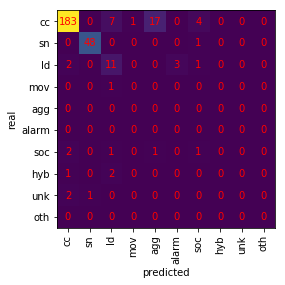

In [62]:
out = model.predict(X)
preds = np.zeros(out.shape[0],dtype='int')
for i in range(out.shape[0]):
    preds[i] = int(np.argmax(out[i,:]))
match = preds == y
acc = np.mean(match)

confusion = np.zeros((len(call_types),len(call_types)))
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        confusion[i,j] = np.sum((y == i) & (preds == j))

plt.xticks(np.arange(start=0,stop=len(call_types)),call_types,rotation='vertical')
plt.yticks(np.arange(start=0,stop=len(call_types)),call_types)
plt.ylabel('real')
plt.xlabel('predicted')
plt.imshow(confusion)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.annotate(text = str(int(confusion[i,j])), xy=(j, i), ha='center',va='center',color='red')
plt.show()

In [ ]:
print(range(ncalls))

In [ ]:
aud=np.load('/home/arianasp/meerkat_detector/clips/agg1532_aud.npy')
print(len(aud))